In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

from Deep_Learning.Experimental.Forward_Forward.nn import FFNet
from Deep_Learning.Experimental.Forward_Forward.gen_neg_data import MakeNegativeSample
from Deep_Learning.Experimental.Forward_Forward.train import unsupervised, unsupervised_tracked

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
# device = torch.device('cpu')
device

device(type='cuda')

  0%|          | 0/48000 [00:00<?, ?it/s]

Loaded MNIST with 48000 samples


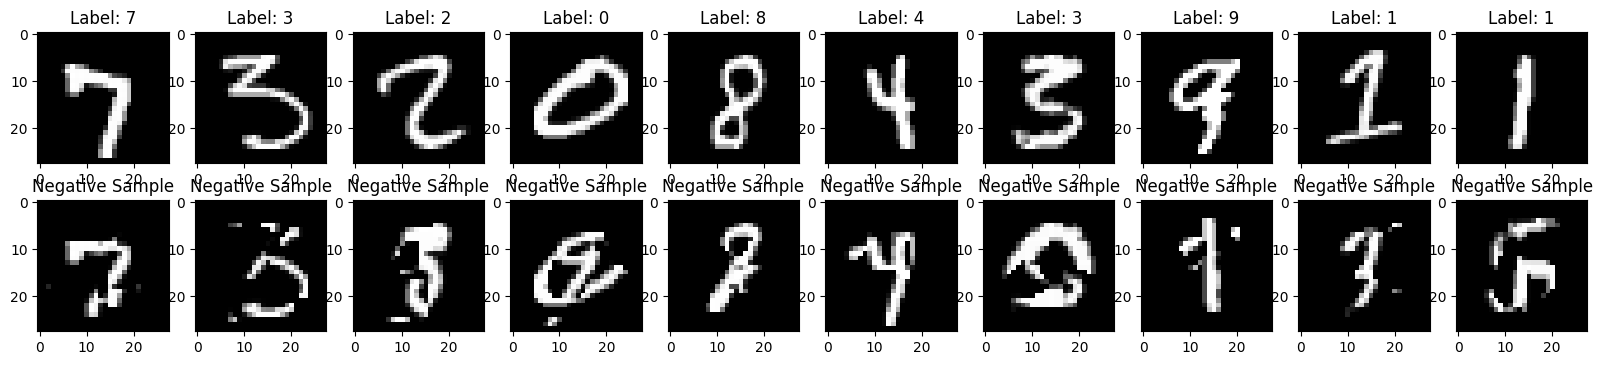

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=True)
# subset_size = 10000
# raw_dataset = torch.utils.data.Subset(raw_dataset, range(subset_size))

VAL_RATIO = 0.2
n_val = int(len(raw_dataset) * VAL_RATIO)
n_train = len(raw_dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [n_train, n_val])

pos_dataset = PreloadedDataset.from_dataset(train_dataset, None, device)
neg_dataset = PreloadedDataset.from_dataset(pos_dataset, MakeNegativeSample(pos_dataset), device)
val_pos_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
val_neg_dataset = PreloadedDataset.from_dataset(val_pos_dataset, MakeNegativeSample(val_pos_dataset), device)

print(f'Loaded MNIST with {len(pos_dataset)} samples')
# show first samples
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0,i].imshow(pos_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[0,i].set_title(f"Label: {pos_dataset[i][1]}")
    # axs[1,i].imshow(np.squeeze(neg_dataset[i][0].cpu().numpy()), cmap='gray')
    axs[1,i].imshow(neg_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[1,i].set_title(f"Negative Sample")
plt.show()

# Train Feedforward Networks Using Forward-Forward

In [4]:
torch.manual_seed(42)
# Parameter Initialisation
sizes = [784, 2000, 2000, 2000, 2000]
ffnet = FFNet(sizes, bias=True, threshold=2, device=torch.device(device))
tracker = None

In [5]:
EPOCHS = 100
BATCH_SIZE = 1000
LR = 0.003
MODE = "minimise"
LOSS = "log"

tracker = unsupervised_tracked(
# tracker = unsupervised(
    ffnet,
    LR,
    pos_dataset,
    neg_dataset,
    val_pos_dataset,
    val_neg_dataset,
    EPOCHS,
    BATCH_SIZE,
    MODE,
    LOSS,
    tracker,
)

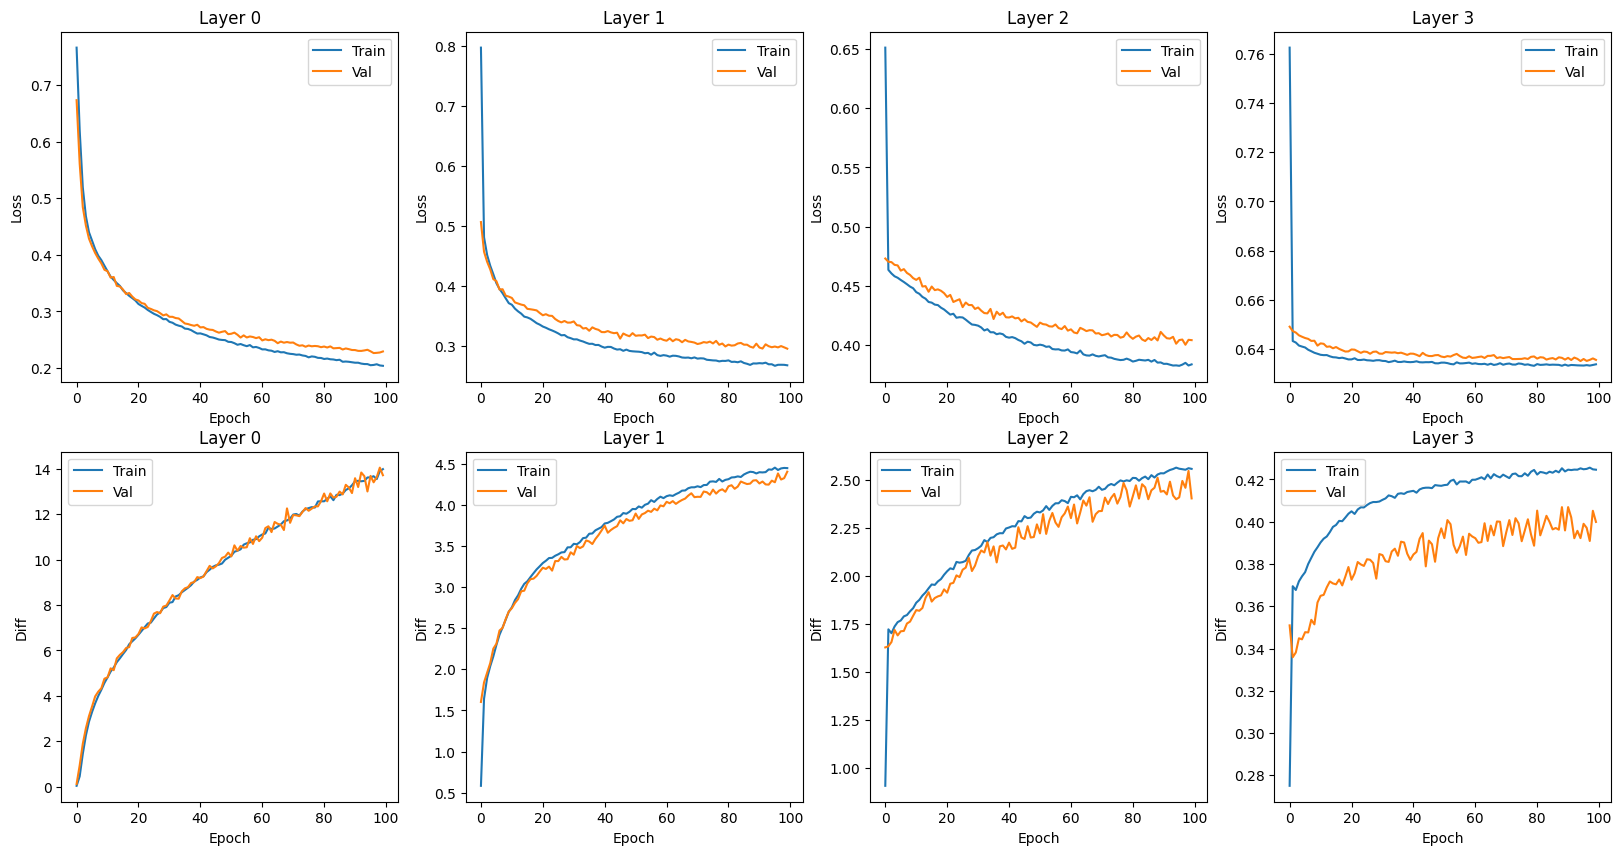

In [6]:
fig, axs = plt.subplots(2, len(ffnet.layers), figsize=(20, 10))
for i, layer in enumerate(ffnet.layers):
    axs[0,i].plot(tracker['layer_losses'][i], label="Train")
    axs[0,i].plot(tracker['layer_val_losses'][i], label="Val")
    axs[0,i].set_title(f"Layer {i}")
    axs[0,i].set_xlabel("Epoch")
    axs[0,i].set_ylabel("Loss")
    axs[0,i].legend()
    axs[1,i].plot(tracker['layer_diffs'][i], label="Train")
    axs[1,i].plot(tracker['layer_val_diffs'][i], label="Val")
    axs[1,i].set_title(f"Layer {i}")
    axs[1,i].set_xlabel("Epoch")
    axs[1,i].set_ylabel("Diff")
    axs[1,i].legend()

Norms / Epochs


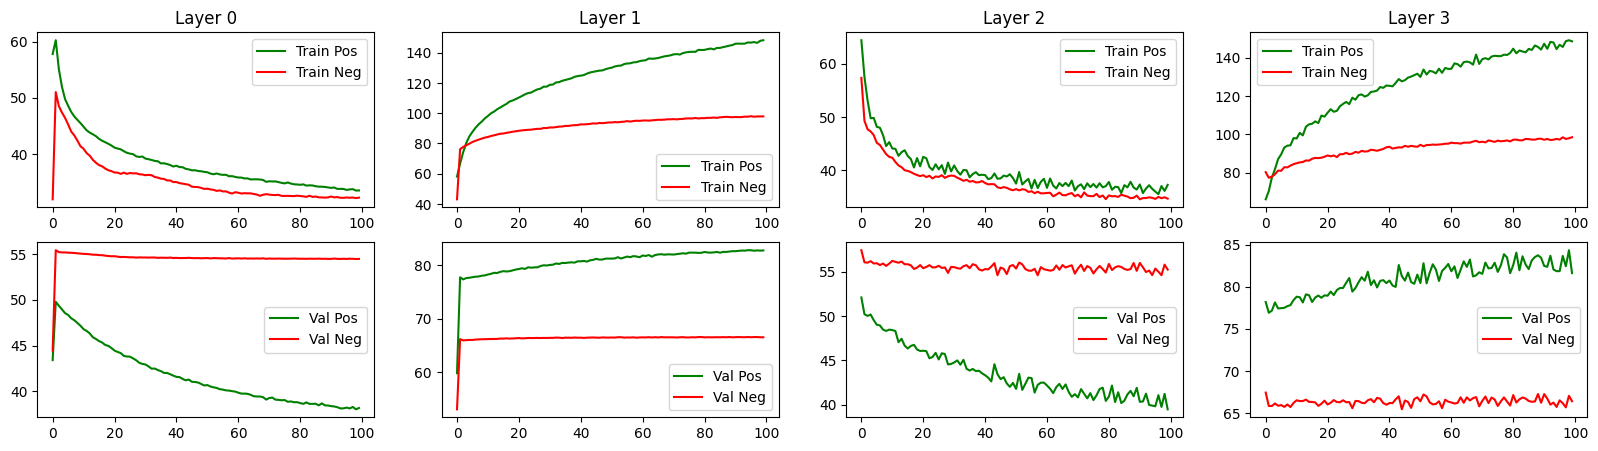

In [9]:
fig, axs = plt.subplots(2, len(ffnet.layers), figsize=(20, 5))
for i in range(len(ffnet.layers)):
    axs[0,i].plot(tracker['norms'][i][0], label="Train Pos", color='g')
    axs[0,i].plot(tracker['norms'][i][1], label="Train Neg", color='r')
    axs[0,i].set_title(f"Layer {i}")
    axs[0,i].legend()
    axs[1,i].plot(tracker['norms'][i][2], label="Val Pos", color='g')
    axs[1,i].plot(tracker['norms'][i][3], label="Val Neg", color='r')
    axs[1,i].legend()
print("Norms / Epochs")

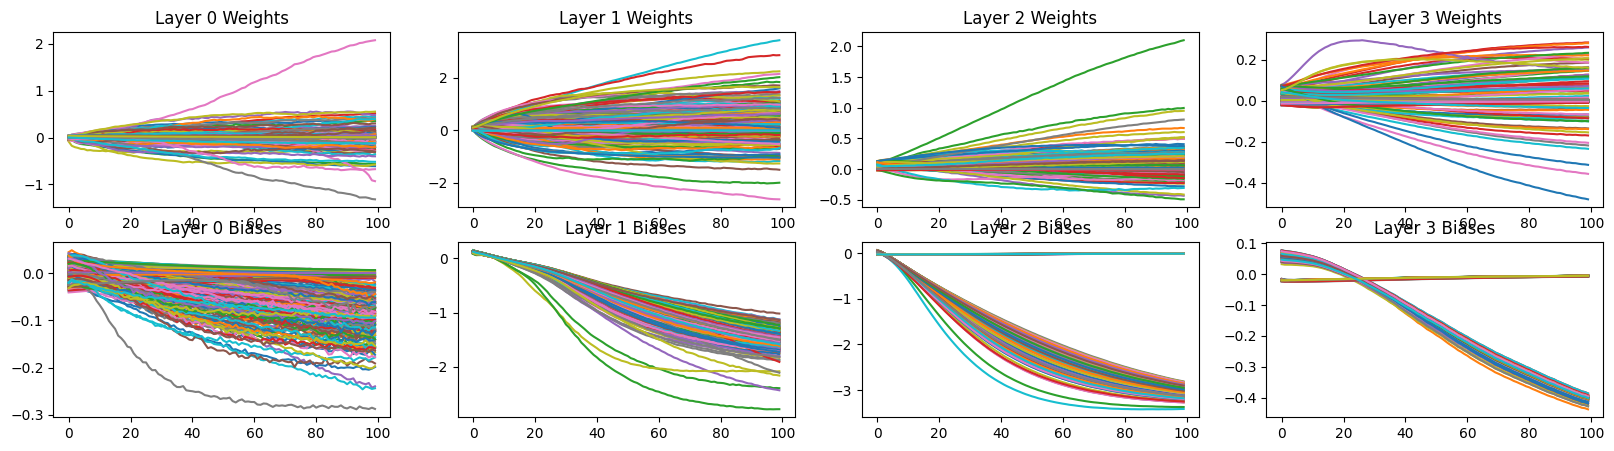

In [10]:
k = 200 # subset size. (must be <= min layer size)
fig, axs = plt.subplots(2, len(ffnet.layers), figsize=(20, 5))
for i in range(len(ffnet.layers)):
    weights = torch.stack(tracker['weights'][i]).flatten(start_dim=1).cpu()
    idxs = torch.randperm(weights.shape[1])[:k]
    weights = weights[:, idxs]
    axs[0,i].plot(weights)
    axs[0,i].set_title(f"Layer {i} Weights")

    if ffnet.layers[i].bias is not None:
        biases = torch.stack(tracker['biases'][i]).cpu()
        idxs = torch.randperm(biases.shape[1])[:k]
        biases = biases[:, idxs]
        axs[1,i].plot(biases)
        axs[1,i].set_title(f"Layer {i} Biases")

# Train Classifier on network activations

In [11]:
def train_classifier(
    ffnet,
    classifier, 
    train_dataset, 
    val_dataset, 
    epochs, 
    batch_size,
    optimiser, 
    criterion, 
    train_loss=[],
    val_loss=[],
    val_acc=[],
    steps = [],
):
    ffnet.eval()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        classifier.train()
        running_loss = 0.0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        if epoch > 0:
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(train_loss=train_loss[-1], val_loss=val_loss[-1], val_acc=val_acc[-1])
        for i, data in loop:
            x, y = data
            with torch.no_grad():
                x = x.flatten(start_dim=1)
                outs = ffnet(x)

            outs = torch.cat(outs[1:], dim=1)
            optimiser.zero_grad()
            y_pred = classifier(outs)
            loss = criterion(y_pred, y)
            loss.backward()
            optimiser.step()

            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))
        if len(steps) > 0:
            steps.append(steps[-1] + len(train_dataset))
        else:
            steps.append(len(train_dataset))

        classifier.eval()
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(val_loader):
            x, y = data
            with torch.no_grad():
                x = x.flatten(start_dim=1)
                outs = ffnet(x)

            outs = torch.cat(outs[1:], dim=1)
            y_pred = classifier(outs)
            loss = criterion(y_pred, y)
            running_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == y).sum().item()
        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / len(val_dataset))

    return train_loss, val_loss, val_acc, steps


In [12]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

in_size = [layer.out_features for layer in ffnet.layers]
in_size = sum(in_size[1:])
print(f"Input size: {in_size}")
classifier = Classifier(in_size, 32, 10).to(device)
optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loss = []
val_loss = []
val_acc = []
steps = []   

Input size: 6000


In [13]:
EPOCHS = 30
BATCH_SIZE = 256

train_loss, val_loss, val_acc, steps = train_classifier(ffnet, classifier, pos_dataset, val_pos_dataset, EPOCHS, BATCH_SIZE, optimiser, criterion, train_loss, val_loss, val_acc, steps)

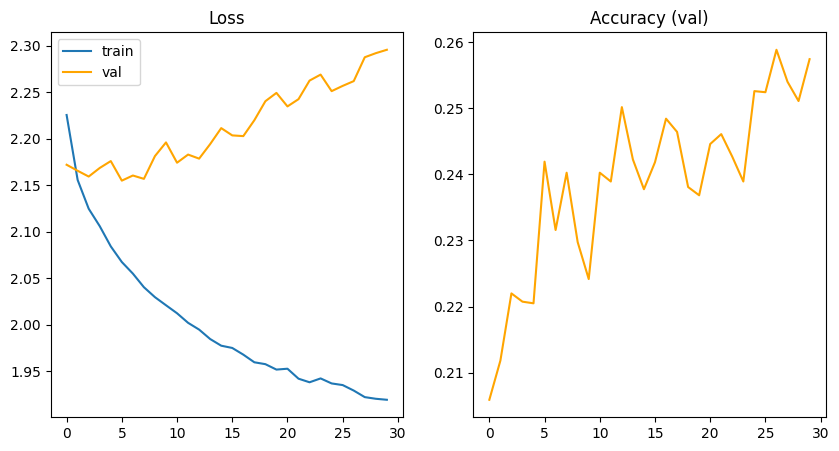

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_loss, label='train')
axs[0].plot(val_loss, label='val', color='orange')
axs[0].legend()
axs[0].set_title('Loss')

axs[1].plot(val_acc, color='orange')
axs[1].set_title('Accuracy (val)')

plt.show()
